In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install tensorflow_addons
!pip install -U scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import AlbertModel, AlbertTokenizer, TFAlbertForSequenceClassification
import sklearn.utils.class_weight
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score

In [ ]:
X_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_train.csv")['review']
y_train = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_train.csv")['sentiment']

X_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_val.csv")['review'].reset_index(drop=True)
y_val = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_val.csv")['sentiment'].reset_index(drop=True)

X_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/X_test.csv")['review'].reset_index(drop=True)
y_test = pd.read_csv("/content/drive/MyDrive/Thesis/dataset/y_test.csv")['sentiment'].reset_index(drop=True)

X_train = X_train.astype(str).dropna()
X_val = X_val.astype(str).dropna()
X_test = X_test.astype(str).dropna()


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

X_train_tokens = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = 250,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

X_val_tokens = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = 250,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

X_test_tokens = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = 250,
    padding = 'max_length',
    truncation=True,
    return_token_type_ids=False
)

X_train_pad = tf.constant(X_train_tokens['input_ids'])
X_train_mask = tf.constant(X_train_tokens['attention_mask'])

X_val_pad = tf.constant(X_val_tokens['input_ids'])
X_val_mask = tf.constant(X_val_tokens['attention_mask'])

X_test_pad = tf.constant(X_test_tokens['input_ids'])
X_test_mask = tf.constant(X_test_tokens['attention_mask'])


# #1 Training(overfit)

In [ ]:
albert_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()
albert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Thesis/ALBERT/stored_models/ALBERT/only_ALBERT_best_model_{epoch:02d}', monitor='val_loss', save_best_only=True, save_format="tf")

history = albert_model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train,
    batch_size=100,
    epochs=200,
    validation_data=([X_val_pad, X_val_mask], y_val),
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)


All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50
2143/2143 [==============================] - ETA: 0s - loss: 0.8584 - sparse_categorical_accuracy: 0.6598

2143/2143 [==============================] - 833s 379ms/step - loss: 0.8584 - sparse_categorical_accuracy: 0.6598 - val_loss: 0.8517 - val_sparse_categorical_accuracy: 0.6625
Epoch 2/50
2143/2143 [==============================] - 762s 355ms/step - loss: 0.8599 - sparse_categorical_accuracy: 0.6594 - val_loss: 0.9150 - val_sparse_categorical_accuracy: 0.6625
Epoch 3/50
2143/2143 [==============================] - ETA: 0s - loss: 0.8559 - sparse_categorical_accuracy: 0.6599

2143/2143 [==============================] - 788s 368ms/step - loss: 0.8559 - sparse_categorical_accuracy: 0.6599 - val_loss: 0.8424 - val_sparse_categorical_accuracy: 0.6625
Epoch 4/50
2143/2143 [==============================] - ETA: 0s - loss: 0.8538 - sparse_categorical_accuracy: 0.6613

2143/2143 [==============================] - 788s 368ms/step - loss: 0.8538 - sparse_categorical_accuracy: 0.6613 - val_loss: 0.8351 - val_sparse_categorical_accuracy: 0.6625
Epoch 5/50
2143/2143 [==============================] - 760s 355ms/step - loss: 0.8561 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.8490 - val_sparse_categorical_accuracy: 0.6625
Epoch 6/50
2143/2143 [==============================] - 760s 355ms/step - loss: 0.8570 - sparse_categorical_accuracy: 0.6594 - val_loss: 0.8760 - val_sparse_categorical_accuracy: 0.6625
Epoch 7/50
2143/2143 [==============================] - 760s 355ms/step - loss: 0.8578 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.8712 - val_sparse_categorical_accuracy: 0.6625
Epoch 8/50
2143/2143 [==============================] - 760s 355ms/step - loss: 0.8554 - sparse_categorical_accuracy: 0.6613 - val_loss: 0.8816 - val_sparse_categorical_accuracy: 0.6625
Epoch 9/50
2143/2143 [==============================] - 759s 354ms/step - loss: 0

1681/1681 [==============================] - 133s 77ms/step


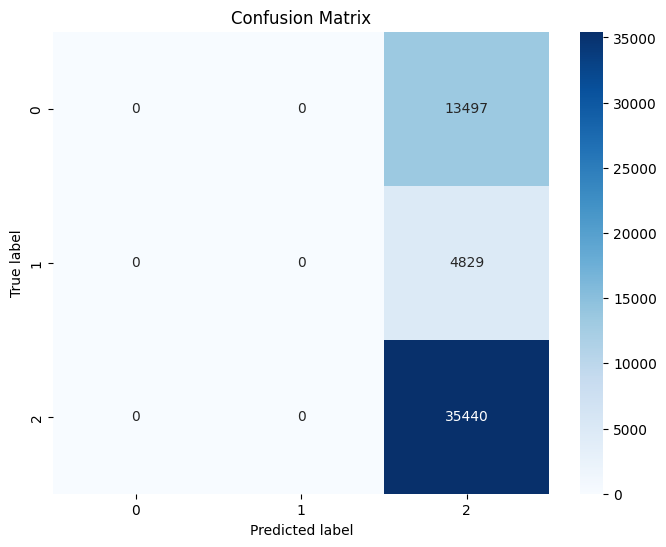

In [ ]:
# Get model predictions on test data
y_pred_output = albert_model.predict([X_test_pad, X_test_mask])
y_pred_logits = y_pred_output.logits
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)
y_pred_labels = tf.argmax(y_pred_prob, axis=1).numpy()


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_labels)
print(report)

# Compute and print micro-averaged F1 score
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-averaged F1 score: ", micro_avg_f1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13497
           1       0.00      0.00      0.00      4829
           2       0.66      1.00      0.79     35440

    accuracy                           0.66     53766
   macro avg       0.22      0.33      0.26     53766
weighted avg       0.43      0.66      0.52     53766

Micro-averaged F1 score:  0.6591526243350817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


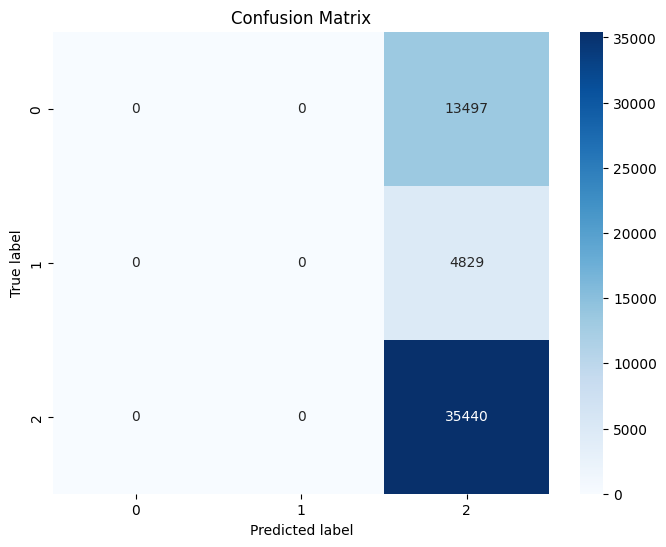

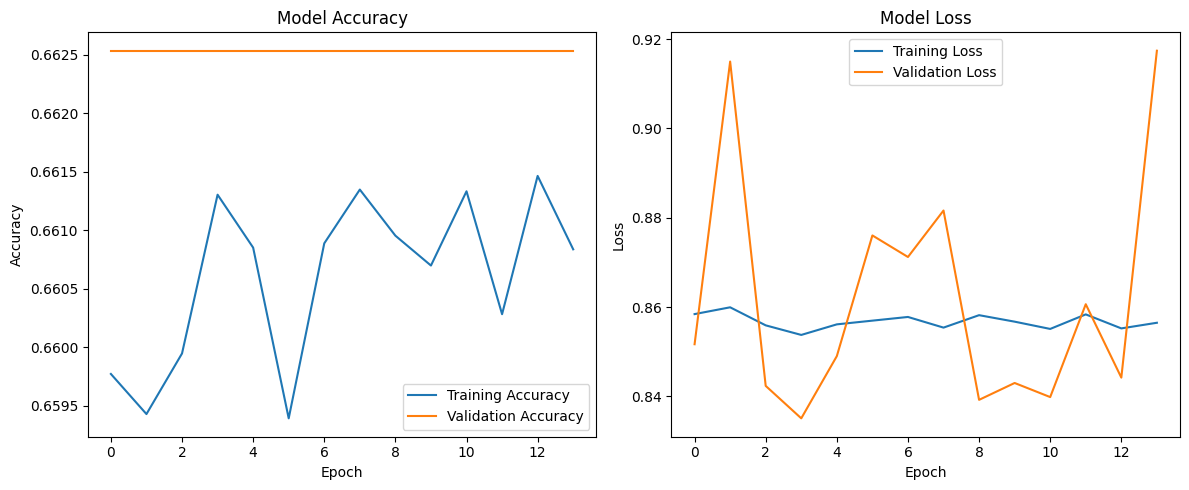

In [ ]:
# 1. Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# 2. Plot accuracy and loss over epochs
# Create a figure
plt.figure(figsize=(12,5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the figure with the plots
plt.tight_layout()
plt.show()


1681/1681 [==============================] - 132s 77ms/step


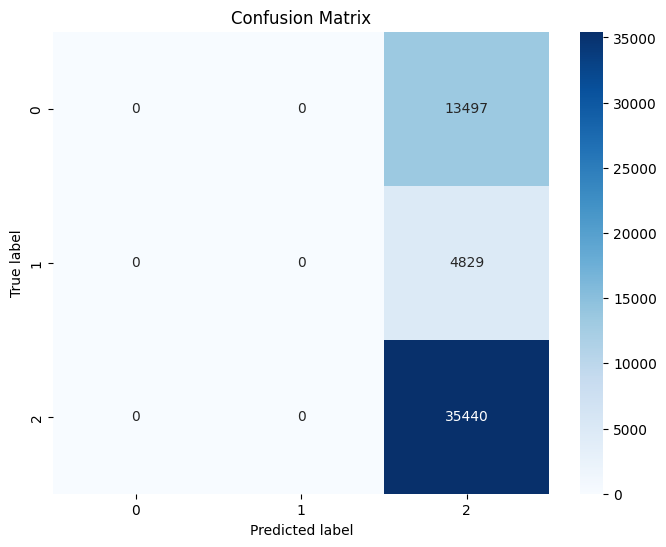

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13497
           1       0.00      0.00      0.00      4829
           2       0.66      1.00      0.79     35440

    accuracy                           0.66     53766
   macro avg       0.22      0.33      0.26     53766
weighted avg       0.43      0.66      0.52     53766

Micro-averaged F1 score:  0.6591526243350817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score
# Get model predictions on test data
y_pred_output = albert_model.predict([X_test_pad, X_test_mask])
y_pred_logits = y_pred_output.logits
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)
y_pred_labels = tf.argmax(y_pred_prob, axis=1).numpy()


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
# Generate classification report
report = classification_report(y_test, y_pred_labels)
print(report)

# Compute and print micro-averaged F1 score
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-averaged F1 score: ", micro_avg_f1)

# #2 Training 1 epoch

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1372/1372 [==============================] - ETA: 0s - loss: 0.5597 - sparse_categorical_accuracy: 0.7876

1681/1681 [==============================] - 132s 77ms/step


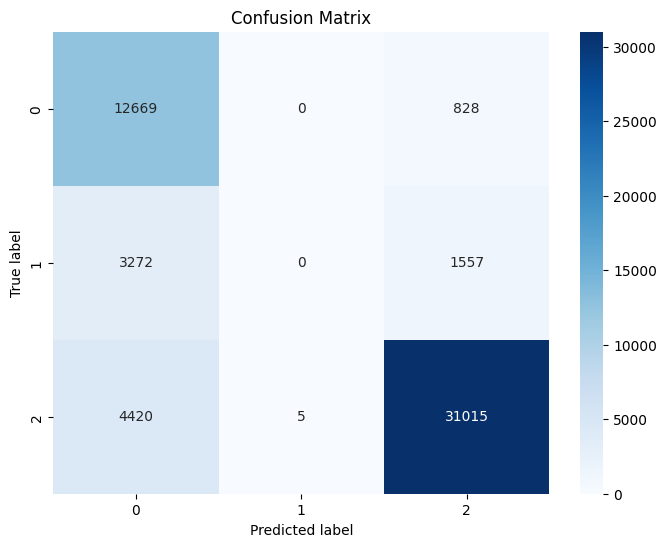

              precision    recall  f1-score   support

           0       0.62      0.94      0.75     13497
           1       0.00      0.00      0.00      4829
           2       0.93      0.88      0.90     35440

    accuracy                           0.81     53766
   macro avg       0.52      0.60      0.55     53766
weighted avg       0.77      0.81      0.78     53766

Micro-averaged F1 score:  0.812483725774653


In [ ]:
# Define the model architecture
albert_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

# Set up the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # For integer labels
metrics = tf.metrics.SparseCategoricalAccuracy()  # For integer labels

# Compile the model
albert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Define callbacks for early stopping and model checkpointing
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Thesis/ALBERT/stored_models/ALBERT/only_ALBERT_best_model_{epoch:02d}', monitor='val_loss', save_best_only=True, save_format="tf")

# Fit the model
history = albert_model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train,
    batch_size=100,
    epochs=1,
    validation_data=([X_val_pad, X_val_mask], y_val),
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

from sklearn.metrics import f1_score
# Get model predictions on test data
y_pred_output = albert_model.predict([X_test_pad, X_test_mask])
y_pred_logits = y_pred_output.logits
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)
y_pred_labels = tf.argmax(y_pred_prob, axis=1).numpy()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_test, y_pred_labels)
print(report)

# Compute and print micro-averaged F1 score
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-averaged F1 score: ", micro_avg_f1)


# Observe again: initial #3 Training, 1 epoch

In [ ]:
# Define the model architecture
albert_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

# Set up the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # For integer labels
metrics = tf.metrics.SparseCategoricalAccuracy()  # For integer labels

# Compile the model
albert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Define callbacks for early stopping and model checkpointing
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Thesis/ALBERT/stored_models/ALBERT/only_ALBERT_best_model_{epoch:02d}', monitor='val_loss', save_best_only=True, save_format="tf")

# Fit the model
history = albert_model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train,
    batch_size=100,
    epochs=1,
    validation_data=([X_val_pad, X_val_mask], y_val),
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1372/1372 [==============================] - ETA: 0s - loss: 0.5778 - sparse_categorical_accuracy: 0.7813

1372/1372 [==============================] - 788s 559ms/step - loss: 0.5778 - sparse_categorical_accuracy: 0.7813 - val_loss: 0.4836 - val_sparse_categorical_accuracy: 0.8250


In [ ]:
from sklearn.metrics import f1_score
# Get model predictions on test data
y_pred_output = albert_model.predict([X_test_pad, X_test_mask])
y_pred_logits = y_pred_output.logits
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)
y_pred_labels = tf.argmax(y_pred_prob, axis=1).numpy()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Generate classification report
report = classification_report(y_test, y_pred_labels)
print(report)

# Compute and print micro-averaged F1 score
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-averaged F1 score: ", micro_avg_f1)

1681/1681 [==============================] - 133s 77ms/step
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     13497
           1       0.00      0.00      0.00      4829
           2       0.84      0.97      0.90     35440

    accuracy                           0.83     53766
   macro avg       0.54      0.57      0.56     53766
weighted avg       0.75      0.83      0.79     53766

Micro-averaged F1 score:  0.8261354759513447


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Continue training for #3 Training, +2 epoch

In [ ]:
# Now fit the model for 39 more epochs
history = albert_model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train,
    batch_size=100,
    epochs=2,
    validation_data=([X_val_pad, X_val_mask], y_val),
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/2
1372/1372 [==============================] - 734s 535ms/step - loss: 0.4198 - sparse_categorical_accuracy: 0.8434 - val_loss: 0.5001 - val_sparse_categorical_accuracy: 0.7937
Epoch 2/2
1372/1372 [==============================] - ETA: 0s - loss: 0.3518 - sparse_categorical_accuracy: 0.8644

1372/1372 [==============================] - 759s 553ms/step - loss: 0.3518 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.4445 - val_sparse_categorical_accuracy: 0.8408


In [ ]:
from sklearn.metrics import f1_score
# Get model predictions on test data
y_pred_output = albert_model.predict([X_test_pad, X_test_mask])
y_pred_logits = y_pred_output.logits
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)
y_pred_labels = tf.argmax(y_pred_prob, axis=1).numpy()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Generate classification report
report = classification_report(y_test, y_pred_labels)
print(report)

# Compute and print micro-averaged F1 score
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-averaged F1 score: ", micro_avg_f1)

1681/1681 [==============================] - 130s 77ms/step
              precision    recall  f1-score   support

           0       0.85      0.76      0.80     13497
           1       0.28      0.05      0.08      4829
           2       0.85      0.97      0.91     35440

    accuracy                           0.84     53766
   macro avg       0.66      0.59      0.60     53766
weighted avg       0.79      0.84      0.81     53766

Micro-averaged F1 score:  0.8372205483019007


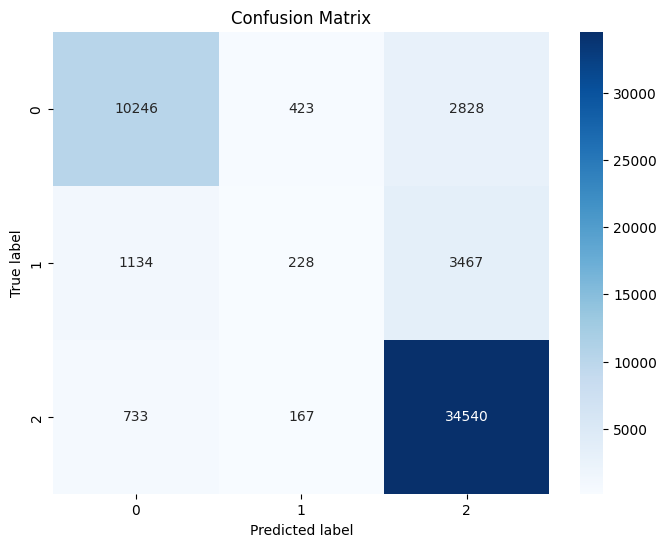

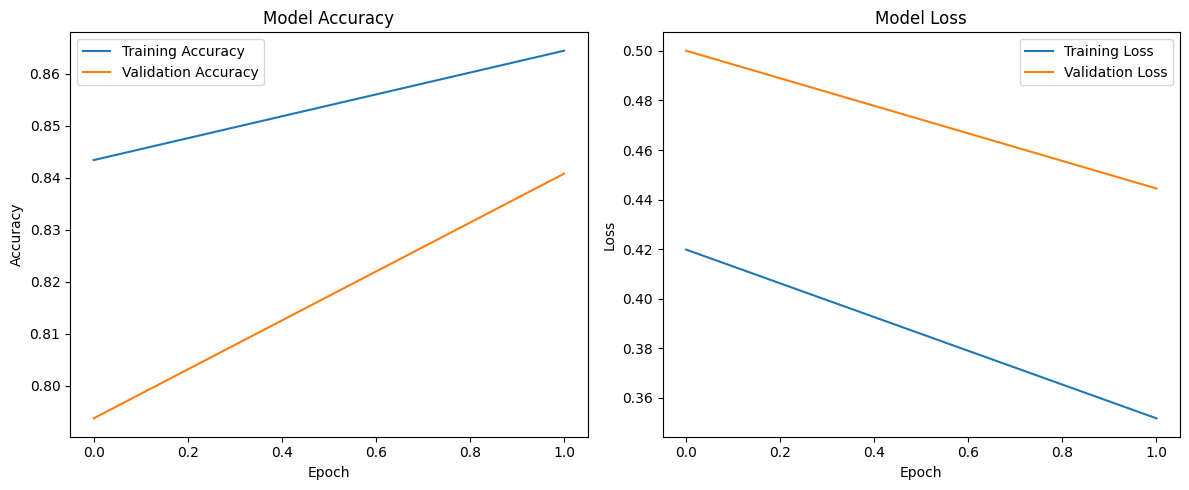

In [ ]:
# 1. Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# 2. Plot accuracy and loss over epochs
# Create a figure
plt.figure(figsize=(12,5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the figure with the plots
plt.tight_layout()
plt.show()


# Continue training for #3 Training, +37 epoch

In [ ]:
# Now fit the model for 39 more epochs
history = albert_model.fit(
    x=[X_train_pad, X_train_mask],
    y=y_train,
    batch_size=100,
    epochs=37,
    validation_data=([X_val_pad, X_val_mask], y_val),
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/37
1372/1372 [==============================] - 733s 535ms/step - loss: 0.2961 - sparse_categorical_accuracy: 0.8854 - val_loss: 0.4635 - val_sparse_categorical_accuracy: 0.8348
Epoch 2/37
1372/1372 [==============================] - ETA: 0s - loss: 0.2487 - sparse_categorical_accuracy: 0.9052

1372/1372 [==============================] - 762s 556ms/step - loss: 0.2487 - sparse_categorical_accuracy: 0.9052 - val_loss: 0.4203 - val_sparse_categorical_accuracy: 0.8408
Epoch 3/37
1372/1372 [==============================] - 734s 535ms/step - loss: 0.2242 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.4389 - val_sparse_categorical_accuracy: 0.8596
Epoch 4/37
1372/1372 [==============================] - 734s 535ms/step - loss: 0.2238 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.4355 - val_sparse_categorical_accuracy: 0.8470
Epoch 5/37
1372/1372 [==============================] - 734s 535ms/step - loss: 0.1831 - sparse_categorical_accuracy: 0.9346 - val_loss: 0.4619 - val_sparse_categorical_accuracy: 0.8601
Epoch 6/37
1372/1372 [==============================] - 734s 535ms/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.4850 - val_sparse_categorical_accuracy: 0.8626
Epoch 7/37
1372/1372 [==============================] - 734s 535ms/step - loss: 0

In [ ]:
from sklearn.metrics import f1_score
# Get model predictions on test data
y_pred_output = albert_model.predict([X_test_pad, X_test_mask])
y_pred_logits = y_pred_output.logits
y_pred_prob = tf.nn.softmax(y_pred_logits, axis=1)
y_pred_labels = tf.argmax(y_pred_prob, axis=1).numpy()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Generate classification report
report = classification_report(y_test, y_pred_labels)
print(report)

# Compute and print micro-averaged F1 score
micro_avg_f1 = f1_score(y_test, y_pred_labels, average='micro')
print("Micro-averaged F1 score: ", micro_avg_f1)

1681/1681 [==============================] - 130s 77ms/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     13497
           1       0.56      0.59      0.58      4829
           2       0.93      0.94      0.94     35440

    accuracy                           0.88     53766
   macro avg       0.78      0.79      0.79     53766
weighted avg       0.88      0.88      0.88     53766

Micro-averaged F1 score:  0.880463489937879


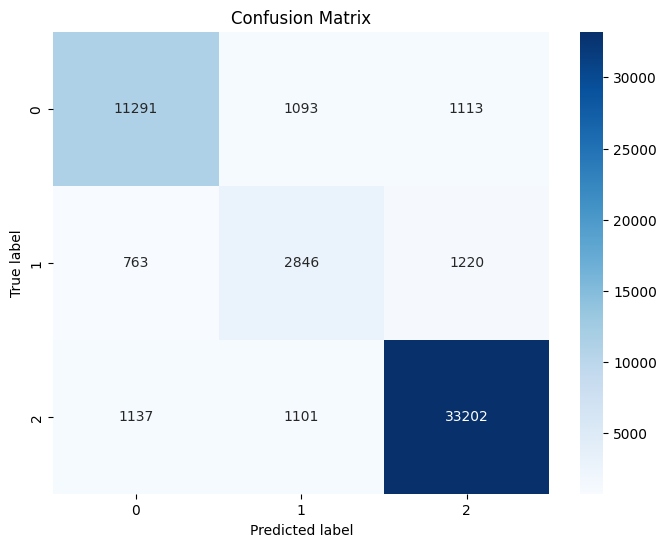

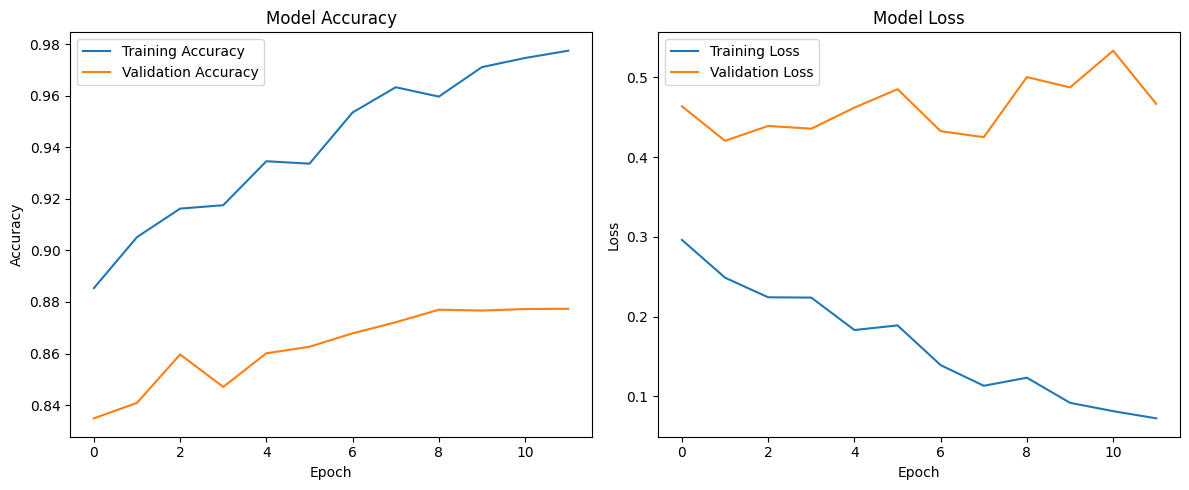

In [ ]:
# 1. Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# 2. Plot accuracy and loss over epochs
# Create a figure
plt.figure(figsize=(12,5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the figure with the plots
plt.tight_layout()
plt.show()
